<a href="https://colab.research.google.com/github/cysdavid/barotropic_public/blob/main/shear_instability_disk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shear instability of zonal flow on a disk

This notebook simulates shear instability of an axisymmetric flow in a disk using the [Dedalus pseudospectral code](https://dedalus-project.readthedocs.io/en/latest/index.html). We consider an initially zonal flow that deviates from solid body rotation: $\boldsymbol{u}(t=0) = U_\phi(s) \boldsymbol{e}_\phi  = [\Omega_0 s + \Delta U_\phi(s)]\boldsymbol{e}_\phi $.

The (non-rotating) equations governing the flow are
$$    \partial_t \boldsymbol{u} + \boldsymbol{u} \cdot \boldsymbol{\nabla} \boldsymbol{u} = -\boldsymbol{\nabla} p + \textit{Ek} \nabla^2 \boldsymbol{u}$$
$$\boldsymbol{\nabla} \cdot \boldsymbol{u} = 0$$
where distances have been scaled by the outer radius $R$ and time has been scaled by the inverse rotation rate $\Omega_0^{-1}$. The Ekman number, defined as $\textit{Ek} = \nu/(\Omega_0 R^2)$, characterizes the strength of viscous diffusion.

A local maximum or minimum in the background vorticity $\overline{\zeta}(s) = s^{-1} \partial_s(s U_\phi)$ may lead to shear instabilities, as demonstrated in the following.

## *Installation*

This notebook uses the [Dedalus](https://dedalus-project.readthedocs.io/en/latest/index.html) package to solve the equations of motion. The following cell checks if Dedalus is installed, and installs it if you are using Google Colab (this should take around 5 minutes).

In [12]:
# This cell from https://nbviewer.org/github/kburns/cism_dedalus_2023/blob/main/lecture_3_2d_turbulence.ipynb

# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## *Content*

Now we can import the packages used in this notebook

In [13]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import dedalus.public as d3
import pathlib
import json
import glob
import warnings
from dedalus.tools.general import natural_sort
import logging
logger = logging.getLogger(__name__)

## 1. Parameters

Set simulation parameters. The shape of $\Delta U_\phi(s)$ (and the size/number of shear layers) may be controlled with the following parameters. For example, you can try setting `bump_w = 0.2` to double the width of the shear layer.

To visualize the initial flow profile, run the following 4 cells. You can go back and change the parameters below as needed.

In [14]:
# File parameters
sim_name = 'sim1' # Rename to avoid over-writing existing data

# Parameters for initial shear layer(s)
bump_type = 'erf' # function to use: 'skewnormal', 'compact', 'erf'
bump_w = 0.1 # width of shear layer(s)
bump_h = -1 # amplitude of shear layer(s)
bump_c = 1 - bump_w/2 # location of shear layer(s)
bump_skew = 0 # skew of shear layer, used if bump_type == 'skewnormal'

# Physical parameters
Ek = 5e-5 # Ekman number
perturbation_amp = 1e-2 # Amplitude of noise

# Numerical parameters
nphi = 256 # Max azimuthal order
ns = 128 # Number of radial grid points
dealias = 3/2
dtype = np.float64
timestepper = d3.RK443

# Cadences and stop time
max_timestep = 2e-3 
output_cadence = 500
stop_sim_time = 1*np.pi
snapshot_dt = 2*np.pi/250

## 2. Simulation code

The the cells in this section set up and run the simulation. (You don't need to edit anything in this section).

### Set up Dedalus domain and fields

In [15]:
# Set up paths and make directories
data_path = pathlib.Path('data').absolute()
params_path = pathlib.Path('params').absolute()
ivp_params_path = params_path.joinpath(sim_name+".json")

# Make problem
## Bases
coords = d3.PolarCoordinates('phi', 's')
dist = d3.Distributor(coords, dtype=dtype)
disk = d3.DiskBasis(coords,shape=(nphi, ns),radius=1,dtype=dtype,dealias=3/2)
phi_grid, s_grid = dist.local_grids(disk)

## Fields
u = dist.VectorField(coords, name='u', bases=disk)
p = dist.Field(name='p', bases=disk)
s = dist.Field(name='s', bases=disk.radial_basis)
s['g'] = s_grid
ses = dist.VectorField(coords, name='ses', bases=disk.radial_basis)
ses['g'][1] = s_grid
tau_u = dist.VectorField(coords, name='tau_u', bases=disk.edge)
tau_p = dist.Field(name='tau_p')
t = dist.Field()

## Substitutions
lift_basis = disk.derivative_basis(2)
lift = lambda A: d3.Lift(A, lift_basis, -1)
avg = lambda A: 1/(np.pi*1**2)*d3.Integrate(A)

### Set initial condition

In [ ]:
# Initial fluid rotation rate
Omega = 1

## Initial condition
### Add incompressible noise
psi = dist.Field(name='psi', bases=disk) # streamfunction
psi.fill_random('g', seed=42, distribution='standard_normal') # Random noise
psi.low_pass_filter(scales=0.5) # Keep only lower half of the modes
u.change_scales(3/2)
u['g'][0] = -d3.grad(psi).evaluate()['g'][1]
u['g'][1] = d3.grad(psi).evaluate()['g'][0]
uamp = np.sqrt(avg(u@u)).evaluate()['g'][0,0]
u['g'] *= perturbation_amp/uamp # normalize 
u.change_scales(1)
### Add background azimuthal flow
u['g'][0] += Omega*s_grid
### Add smooth bump
if bump_type == 'compact':
    bump_func = lambda s: np.piecewise(s, [np.abs(s-bump_c)<bump_w/2, np.abs(s-bump_c)>=bump_w/2], 
                [lambda s: bump_h*np.exp(1)*np.exp(1/(((s-bump_c)/bump_w/2)**2 - 1)), 
                 lambda s: 0])
    Omega_tank = Omega
if bump_type == 'erf':
    Omega_tank = Omega + bump_h
    bump_func = lambda s : bump_h/2 * (1+special.erf(4*(s-bump_c+bump_w/2)/bump_w))
if bump_type == 'skewnormal':
    Omega_tank = Omega
    #### Skew normal distribution
    def skewnorm(x,alpha):
        cumdist = lambda x: 0.5*(1+special.erf(x/np.sqrt(2)))
        normdist = lambda x : 1/np.sqrt(2*np.pi) * np.exp(-x**2/2)
        skewnormdist = 2*normdist(x)*cumdist(alpha*x)
        return skewnormdist
    gamma = 3
    skewgauss_func = lambda s : np.sqrt(2*np.pi) * skewnorm(
        2*np.sqrt(2)*np.sqrt(np.log(gamma))*(s),bump_skew)
    
    #### Correct scale and location
    test_s = np.linspace(-3,3,1024)
    peak_amp = np.max(skewgauss_func(test_s))
    peak_idx = np.argmin(np.abs(skewgauss_func(test_s) - peak_amp))
    left_idx = np.argmin(np.abs(
        skewgauss_func(test_s)[:peak_idx] - 0.01*peak_amp))
    right_idx = np.argmin(
        np.abs(skewgauss_func(test_s)[peak_idx:] - 0.01*peak_amp)) + peak_idx
    true_width = test_s[right_idx] - test_s[left_idx]
    shift_s = true_width/2 - test_s[right_idx]

    bump_func = lambda s : bump_h/peak_amp * skewgauss_func(
        s*true_width/bump_w - shift_s - bump_c*true_width/bump_w)

u['g'][0] += bump_func(s_grid)

u.change_scales(1)
p.change_scales(1)

### Plot initial condition

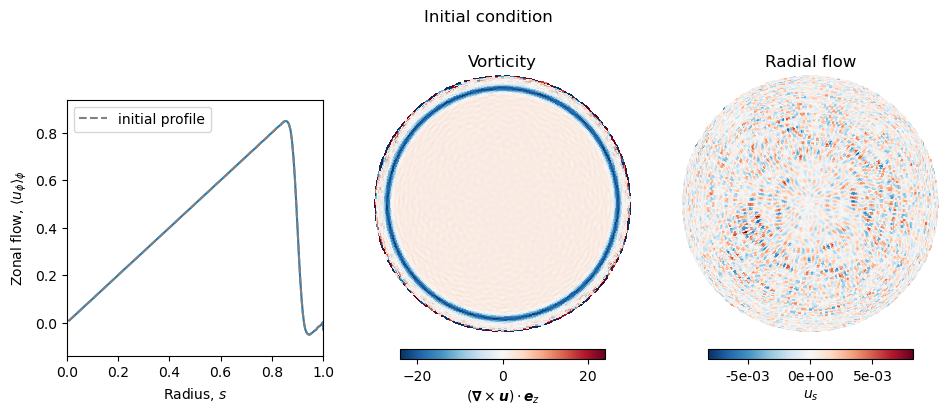

In [17]:
vort = (-d3.div(d3.skew(u))).evaluate()
vort.change_scales(1)
u.change_scales(1)
vort_data = vort['g']
vort_vmin = np.quantile(np.abs(vort_data),q=0.95)
us_data = u['g'][1]
us_vmin = np.quantile(np.abs(us_data),q=1)
uphiavg = uphiavg_init = np.mean(u['g'][0],axis=0)
uphi_min, uphi_max = (np.min(uphiavg),np.max(uphiavg))

plot_dict = {"s":s_grid[0],"phi":phi_grid[:,0],
             "uphiavg_init":uphiavg_init,"uphiavg":uphiavg,
             "uphi_min":uphi_min,"uphi_max":uphi_max,
             "vort_data":vort_data,"vort_vmin":vort_vmin,
             "us_data":us_data,"us_vmin":us_vmin}

def plot_snapshot(dic,dpi=100):
    ss,phiphi = np.meshgrid(dic["s"],dic["phi"])
    xx = ss * np.cos(phiphi)
    yy = ss * np.sin(phiphi)
    fig, axs = plt.subplot_mosaic([['uphi','vort','us']],figsize=(11.25,4.5),dpi=dpi)
    cmap = "RdBu_r"

    line, = axs['uphi'].plot(dic["s"],dic["uphiavg"])
    axs['uphi'].plot(dic["s"],dic["uphiavg_init"],color='gray',
                     linestyle='--',label='initial profile')
    ylim_l = dic["uphi_min"] - 0.1*(dic["uphi_max"] - dic["uphi_min"])
    ylim_r = dic["uphi_max"] + 0.1*(dic["uphi_max"] - dic["uphi_min"])
    axs['uphi'].set_ylim(ylim_l,ylim_r)
    axs['uphi'].set_xlim(0,1)
    axs['uphi'].set_ylabel(r"Zonal flow, $\langle u_\phi \rangle_\phi$")
    axs['uphi'].set_xlabel(r"Radius, $s$")
    axs['uphi'].set_aspect(1/(ylim_r - ylim_l))
    axs['uphi'].legend(loc='upper left')

    with warnings.catch_warnings(action="ignore"):
        vmin = (-dic["vort_vmin"],dic["vort_vmin"])
        pmesh_vort = axs['vort'].pcolormesh(xx, yy, dic["vort_data"], vmin=vmin, cmap=cmap)
        label = r"$(\boldsymbol{\nabla} \times \boldsymbol{u})\cdot \boldsymbol{e}_z$"
        plt.colorbar(pmesh_vort,ax=axs['vort'],orientation="horizontal",
                     pad=0.05,shrink=0.8,label=label)
        axs['vort'].set_aspect('equal')
        axs['vort'].set_axis_off()
        axs['vort'].set_title(r"Vorticity")

        vmin = (-dic["us_vmin"],dic["us_vmin"])
        pmesh_us = axs['us'].pcolormesh(xx, yy, dic["us_data"], vmin=vmin, cmap=cmap)
        plt.colorbar(pmesh_us,ax=axs['us'],orientation="horizontal",
                     pad=0.05,shrink=0.8,label=r"$u_s$",format='%.0e')
        axs['us'].set_aspect('equal')
        axs['us'].set_axis_off()
        axs['us'].set_title(r"Radial flow")

    return fig, line, pmesh_vort, pmesh_us

_ = plot_snapshot(plot_dict)
plt.suptitle("Initial condition")
plt.show()

### Build Dedalus problem

In [18]:
## Problem
problem = d3.IVP([u, p, tau_u, tau_p], time=t, namespace=locals())
problem.add_equation("div(u) + tau_p = 0")
problem.add_equation("dt(u) + grad(p) - Ek*lap(u) + lift(tau_u) = - u@grad(u)")
problem.add_equation("integ(p) = 0")

# non-axisymmetric modes
problem.add_equation("radial( u(s=1) ) = 0", condition='nphi!=0')
problem.add_equation("azimuthal( u(s=1) ) = 0", condition='nphi!=0')

# axisymmetric modes
problem.add_equation("radial( u(s=1) ) = 0", condition='nphi==0')
problem.equations[-1]['valid_modes'][1] = True
problem.add_equation("azimuthal( u(s=1) ) = Omega_tank*1", condition='nphi==0')
problem.equations[-1]['valid_modes'][1] = True

# Build solver
solver = problem.build_solver(timestepper)
logger.info('Solver built')

# Integration parameters
solver.stop_sim_time = stop_sim_time

# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.2, threshold=0.1,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Create data and params directories if needed
save_data_path = data_path.joinpath(sim_name)
save_params_path = params_path.joinpath(sim_name+".json")
if not data_path.exists():
    data_path.mkdir()
if not params_path.exists():
    params_path.mkdir()
if not save_data_path.exists():
    save_data_path.mkdir()

# Save parameters
params_dict = {'ns':ns,'nphi':nphi,'max_timestep':max_timestep,
                'Ek':Ek,'bump_w':bump_w, 'bump_h':bump_h,
                'bump_c':bump_c, 'bump_type':bump_type, 'bump_skew':bump_skew,
                'Omega':Omega,'Omega_tank':Omega_tank,
                'perturbation_amp':perturbation_amp,
                'stop_sim_time':stop_sim_time}
params_json = json.dumps(params_dict, indent = 4)
with open(save_params_path, "w") as outfile: 
    outfile.write(params_json)

2025-07-16 09:18:37,946 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 3s, Rate: 4.4e+01/s
2025-07-16 09:18:38,147 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 5.8e+01/s
2025-07-16 09:18:38,363 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 0s, Remaining: 2s, Rate: 5.9e+01/s
2025-07-16 09:18:38,583 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 1s, Remaining: 2s, Rate: 5.9e+01/s
2025-07-16 09:18:38,799 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 1s, Remaining: 1s, Rate: 5.9e+01/s
2025-07-16 09:18:39,015 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 6.0e+01/s
2025-07-16 09:18:39,232 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 1s, Remaining: 1s, Rate: 6.0e+01/s
2025-07-16 09:18:39,501 subsystems 0/1 INFO :: Building subprobl

### Run simulation

The following cell takes at least 5 minutes to run (15 minutes on Google Colab).

In [19]:
# Analysis
snapshots = solver.evaluator.add_file_handler(str(save_data_path), sim_dt=snapshot_dt, max_writes=1000)
snapshots.add_task(u)
snapshots.add_task(p)
snapshots.add_task(-d3.div(d3.skew(u)),name='vort')
snapshots.add_task(0.5*avg(u@u),name='KE')

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=output_cadence)
flow.add_property(np.abs(u@ses/s), name='abs(us)')
flow.add_property(np.abs(p), name='abs(p)')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % output_cadence == 0:
            max_p = flow.max('abs(p)')
            max_us = flow.max('abs(us)')
            logger.info("Iteration=%i, Time=%e, dt=%e, max|u_s|=%e, max|p|=%e" 
                        %(solver.iteration, solver.sim_time, timestep, max_us, max_p))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2025-07-16 09:18:41,824 __main__ 0/1 INFO :: Starting main loop
2025-07-16 09:18:50,184 __main__ 0/1 INFO :: Iteration=1, Time=2.000000e-03, dt=2.000000e-03, max|u_s|=9.046161e-03, max|p|=0.000000e+00
2025-07-16 09:19:44,645 __main__ 0/1 INFO :: Iteration=501, Time=9.639644e-01, dt=1.799813e-03, max|u_s|=6.972344e-02, max|p|=2.381344e-01
2025-07-16 09:20:40,577 __main__ 0/1 INFO :: Iteration=1001, Time=1.758192e+00, dt=1.294501e-03, max|u_s|=3.677117e-01, max|p|=2.485581e-01
2025-07-16 09:21:35,993 __main__ 0/1 INFO :: Iteration=1501, Time=2.405442e+00, dt=1.294501e-03, max|u_s|=3.797800e-01, max|p|=2.594354e-01
2025-07-16 09:22:31,839 __main__ 0/1 INFO :: Iteration=2001, Time=3.052692e+00, dt=1.294501e-03, max|u_s|=4.160127e-01, max|p|=2.665538e-01
2025-07-16 09:22:39,487 solvers 0/1 INFO :: Simulation stop time reached.
2025-07-16 09:22:39,487 solvers 0/1 INFO :: Final iteration: 2070
2025-07-16 09:22:39,487 solvers 0/1 INFO :: Final sim time: 3.142012975280265
2025-07-16 09:22:39,48

# 3. Plot the results

In [20]:
from matplotlib import animation
from IPython.display import HTML

In [21]:
plot_sim_name = sim_name # Change to plot data from a previous simulation
dpi = 100

Make an animation of the flow:

In [22]:
plot_data_path = data_path.joinpath(plot_sim_name)
data_files = natural_sort(glob.glob(str(plot_data_path.joinpath('*.h5'))))

with h5py.File(data_files[0], mode='r') as file:

    # Plot writes
    ## Open datasets
    u_dset = file['tasks']['u']
    vort_dset = file['tasks']['vort']
    t_dset = u_dset.dims[0]['sim_time']
    phi_data = file['tasks']['u'].dims[2][0][:]
    s_data = file['tasks']['u'].dims[3][0][:]

    # Compute averages and colorbar limits
    uphiavg_init = np.mean(u_dset[0],axis=1)[0,:]
    uphiavg = uphiavg_init
    uphi_min = np.min(np.mean(u_dset,axis=2)[:,0,:])
    uphi_max = np.max(np.mean(u_dset,axis=2)[:,0,:])
    vort_data = vort_dset[0]
    vort_min = np.quantile(np.abs(vort_dset[:]),q=0.95)
    us_data = u_dset[0,1,...]
    us_vmin = np.quantile(np.abs(u_dset[:,1,...]),q=1)

    plot_dict = {"s":s_data,"phi":phi_data,
             "uphiavg_init":uphiavg_init,"uphiavg":uphiavg,
             "uphi_min":uphi_min,"uphi_max":uphi_max,
             "vort_data":vort_data,"vort_vmin":vort_vmin,
             "us_data":us_data,"us_vmin":us_vmin}

    # Plot first frame
    fig, line, pmesh_vort, pmesh_us = plot_snapshot(plot_dict,dpi=dpi)
    plt.suptitle(f"$t \\Omega_0/(2 \\pi) = {t_dset[0]/(2*np.pi):.2f}$")

    # Animate
    def animate(i):
        uphiavg_data = np.mean(u_dset[i],axis=1)[0,:]
        vort_data = vort_dset[i]
        us_data = u_dset[i,1,...]
        line.set_data(s_data,uphiavg_data)
        pmesh_vort.set_array(vort_data.ravel())
        pmesh_us.set_array(us_data.ravel())
        t = t_dset[i]
        plt.suptitle(f"$t \\Omega_0/(2 \\pi) = {t/(2*np.pi):.2f}$")
        return pmesh_vort,pmesh_us

    anim = animation.FuncAnimation(fig, animate, frames=vort_dset.shape[0], interval=50, blit=True)
    video = HTML(anim.to_html5_video())
    plt.close(fig)

video.data = video.data.replace('autoplay', '')
video

2025-07-16 09:22:39,735 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-07-16 09:22:39,736 matplotlib.animation 0/1 INFO :: figure size in inches has been adjusted from 11.25 x 4.5 to 11.24 x 4.5
2025-07-16 09:22:39,736 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1124x450 -pix_fmt rgba -framerate 20.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/yd/tkqkm36d6bz3nhw653thl3ph0000gn/T/tmpocxv28hd/temp.m4v
